In [7]:
from vectorgeo.raster import RasterPatches
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
import os
import pandas as pd
from collections import Counter
from h3 import h3
from scipy.sparse import csr_matrix

def calculate_h3_index(row, resolution=7):
    minx, maxx, miny, maxy = row['minx'], row['maxx'], row['miny'], row['maxy']
    latitude = (miny + maxy) / 2
    longitude = (minx + maxx) / 2
    return h3.geo_to_h3(latitude, longitude, resolution)

# Initialize the global counter for place types
global_counter = Counter()

# Initialize the counter-of-counters for H3 indices
h3_counter = Counter()

# Directory containing the parquet files
places_dir = "/home/ubuntu/vectorgeo/tmp/theme=places/type=place"

# Iterate over all files in the directory
files_to_load = os.listdir(places_dir)[0:2]
for i, place_filename in enumerate(files_to_load):
    print(f"    Loading file {i+1} / {len(files_to_load)}")
    filepath = os.path.join(places_dir, place_filename)
    
    if not os.path.isfile(filepath):
        continue
    
    places_df = pd.read_parquet(filepath)
    
    # Update the global counter for place types
    local_counts = places_df['categories'].apply(lambda x: x['main']).value_counts()
    global_counter.update(local_counts.to_dict())
    
    # Calculate H3 index and update the counter-of-counters
    places_df['h3_index'] = places_df['bbox'].apply(calculate_h3_index)
    for h3_index, group_df in places_df.groupby('h3_index'):
        local_counts = group_df['categories'].apply(lambda x: x['main']).value_counts()
        if h3_index not in h3_counter:
            h3_counter[h3_index] = Counter()
        h3_counter[h3_index].update(local_counts.to_dict())

# Get the top 1000 most common place types
top_1000_places = [place for place, _ in global_counter.most_common(1000)]
top_1000_places = sorted(top_1000_places)

# Create a sparse matrix
h3_indices = sorted(h3_counter.keys())
place_indices = {place: i for i, place in enumerate(top_1000_places)}

rows, cols, data = [], [], []
for row, h3_index in enumerate(h3_indices):
    for place, count in h3_counter[h3_index].items():
        if place in place_indices:
            col = place_indices[place]
            rows.append(row)
            cols.append(col)
            data.append(count)

sparse_matrix = csr_matrix((data, (rows, cols)), shape=(len(h3_indices), len(top_1000_places)))

# Create a DataFrame to map row indices to H3 indices
h3_index_df = pd.Series({'row_index': range(len(h3_indices)), 'h3_index': h3_indices})

# Create a DataFrame to map column indices to place names
place_name_df = pd.DataFrame({'col_index': range(len(top_1000_places)), 'place_name': top_1000_places})

# Now, sparse_matrix is the feature matrix you can use for downstream machine learning.
# h3_index_df and place_name_df can be used to map row and column indices back to H3 indices and place names, respectively.


    Loading file 1 / 2
    Loading file 2 / 2


In [3]:
import h5py

hdf_path = "/home/ubuntu/vectorgeo/tmp/train.h5"

# Load the HDF5 file
hdf = h5py.File(hdf_path, 'r')

# List all datasets in the file
for key in hdf.keys():
    print(key)

# Load first 3 elements of all_data
all_data = hdf['all_data'][:3]

all_data


In [5]:
from vectorgeo.raster import RasterPatches
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import metaflow as mf
import torch


In [6]:
data = list(mf.Flow("TrainLandCoverTripletFlow") \
    .latest_successful_run \
    .steps())[0] \
    .task \
    .data

In [7]:
test_batch_tensor = torch.tensor(data.test_batch, dtype=torch.float32).to(
            data.device
        )
with torch.no_grad():
    zs = data.embedding_network(test_batch_tensor).cpu().numpy()

In [1]:
import h5py
import numpy as np

hdf_path = "/home/ubuntu/vectorgeo/tmp/train.h5"

# Read the first 5 elements of the HDF5 file
array = np.array(h5py.File(hdf_path, 'r')['train_data'][:5])
print(array.shape)

(5, 3, 24, 32, 32)


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import os 
import numpy as np
from sklearn.cluster import KMeans

# Iterate over all files in ./tmp and load the ones with "-lcd-" in the filename
# then, subsample 1% of rows at random and take the columns labeled lat / lng
# and make a scatter plot

# Iterate over all files in the directory
files_to_load = os.listdir("./tmp")

lats = []
lngs = []
df = pd.DataFrame()
for i, filename in enumerate(files_to_load):
    if "-lcd-" not in filename:
        continue
    print(f"    Loading file {i+1} / {len(files_to_load)}")
    filepath = os.path.join("./tmp", filename)
    df_partial = pd.read_parquet(filepath)

    # Subsample 1% of rows at random
    df_partial = df_partial.sample(frac=0.05)
    df = pd.concat([df, df_partial])

lngs = df['lng'].tolist()
lats = df['lat'].tolist()

# Take list-valued vector column and convert to ndarray
xs = np.array(df['vector'].tolist())

# Apply KMeans with 100 clusters
# and add cluster labels to the DataFrame
kmeans = KMeans(n_clusters=20)
df['cluster'] = kmeans.fit_predict(xs)

plt.figure(figsize=(30, 20))
plt.scatter(lngs, lats, s=0.5, c=df['cluster'], cmap='tab20')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
#plt.savefig("./figures/clusters.png", dpi=500)

    Loading file 4 / 132
    Loading file 6 / 132
    Loading file 8 / 132
    Loading file 11 / 132


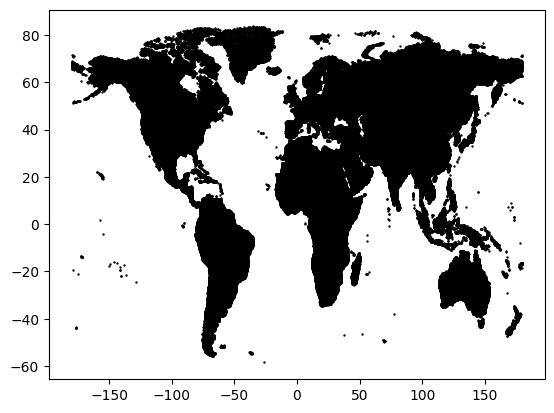

In [10]:
import h3
import json

h3_filename = f"h3s-processed-7.json"
h3_filepath = os.path.join('./tmp', h3_filename)

with open(h3_filepath, 'r') as f:
    h3s = json.load(f)

# Take every 100th H3 index
# and convert to lat-long
lats = []
lngs = []

for h3_index in h3s[::100]:
    lat, lng = h3.h3_to_geo(h3_index)
    lats.append(lat)
    lngs.append(lng)

plt.scatter(lngs, lats, s=0.5, c='black')



In [ ]:
from vectorgeo import transfer, constants as c

key = f"models/{self.model_filename}"
local_model_path = os.path.join(c.TMP_DIR, self.model_filename)
transfer.download_file(key, local_model_path)

# Load the PyTorch model
self.model = torch.load(local_model_path).to(self.device)
self.model.eval()
print(f"Loaded model from {key}")

lc_generator = RasterPatches(
    c.LC_LOCAL_PATH, self.world_gdf, self.image_size, c.LC_RES_M, full_load=True
)

dem_generator = RasterPatches(
    c.DEM_LOCAL_PATH, self.world_gdf, self.image_size, c.DEM_RES_M, full_load=True
)


In [3]:
import numpy as np
from scipy.signal import convolve2d

# Define a small 4x4 grayscale image
image = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

# Define a trivial 3x3 filter for masked convolution
def get_masked_filter(mask_type):
    filter = np.array([
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ])
    
    if mask_type == "V":
        # Mask for vertical convolution:
        filter[1, 1:] = 0
        filter[2, :] = 0
    elif mask_type == "H":
        # Mask for horizontal convolution:
        filter[1, 2:] = 0
        filter[2, :] = 0
        
    return filter

# Gated activation function
def gated_activation(tanh_part, sigmoid_part):
    return np.tanh(tanh_part) * (1 / (1 + np.exp(-sigmoid_part)))

# Forward pass for a single Gated Convolutional Block
def gated_pixelcnn_block(image):
    # Vertical convolution
    v_filter = get_masked_filter("V")
    v_conv = convolve2d(image, v_filter, mode='same', boundary='wrap')
    v_tanh, v_sigmoid = np.split(v_conv, 2, axis=1)
    v_out = gated_activation(v_tanh, v_sigmoid)
    
    # Horizontal convolution
    h_filter = get_masked_filter("H")
    h_conv = convolve2d(image, h_filter, mode='same', boundary='wrap')
    h_tanh, h_sigmoid = np.split(h_conv, 2, axis=1)
    h_out = gated_activation(h_tanh + v_out, h_sigmoid)
    
    return v_out, h_out

v_out, h_out = gated_pixelcnn_block(image)
print("Vertical Output:", v_out)
print("Horizontal Output:", h_out)


Vertical Output: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Horizontal Output: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
